/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


2025-01-15 12:01:46,909 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2025-01-15 12:01:47,163 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


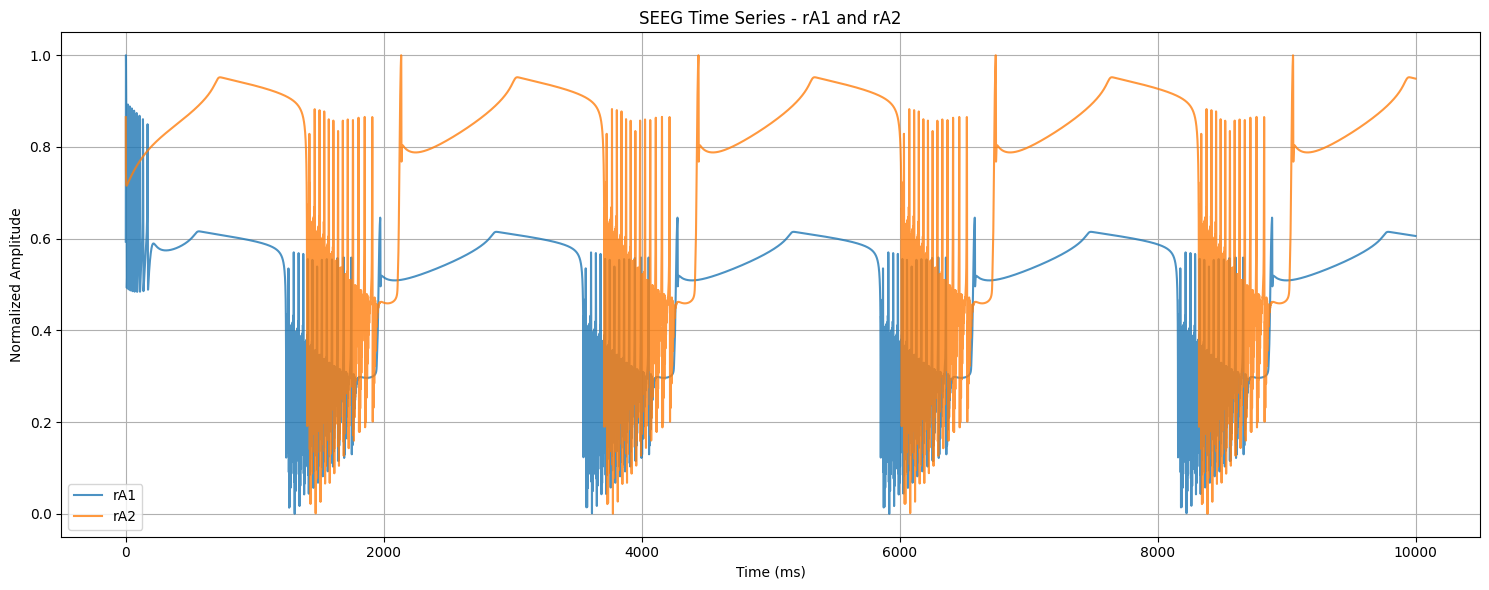

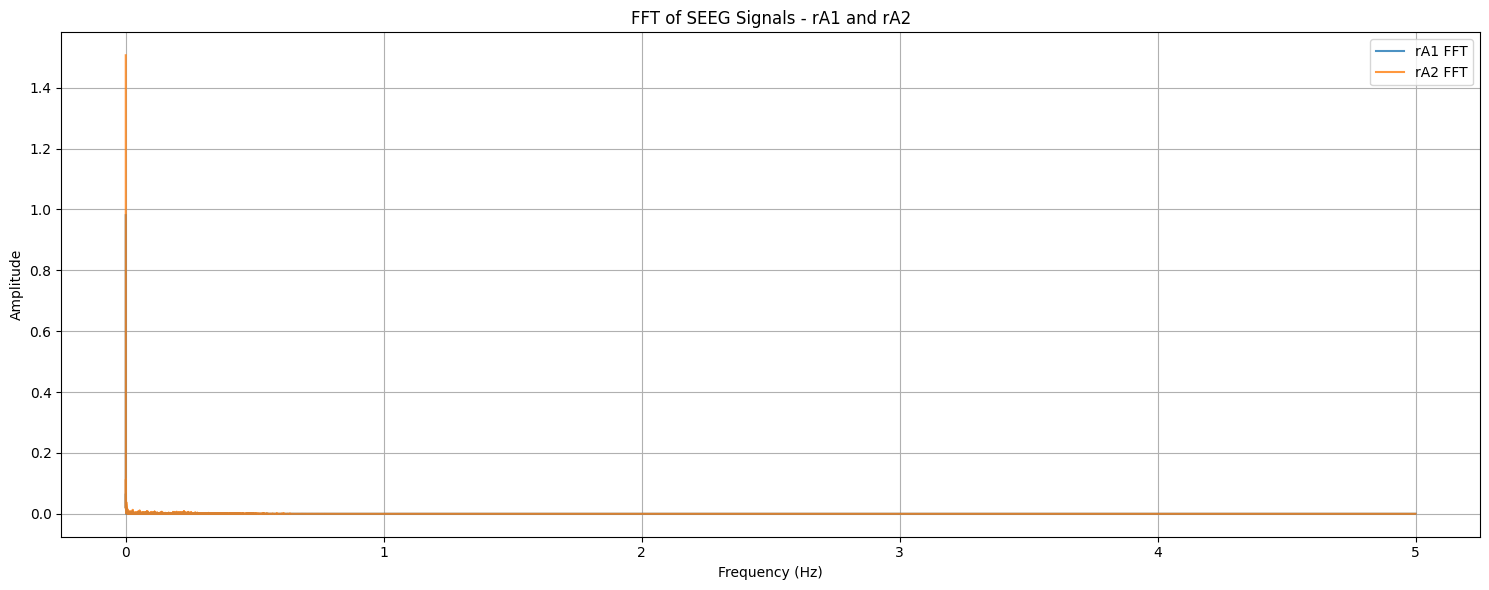

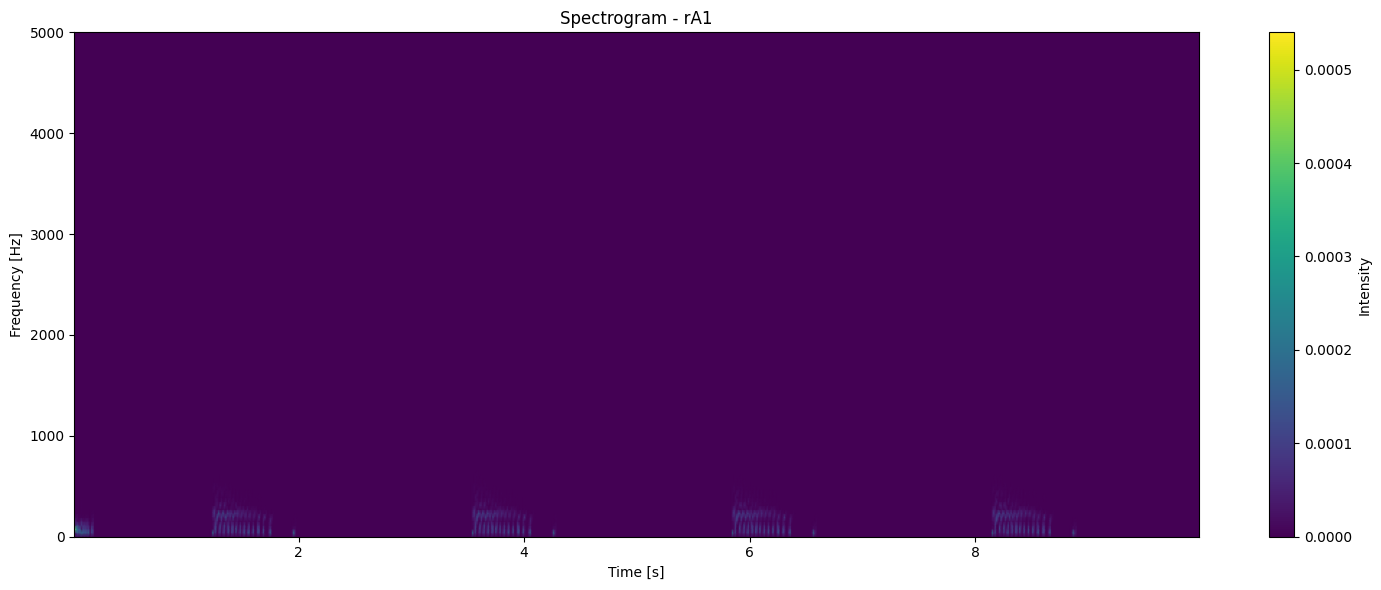

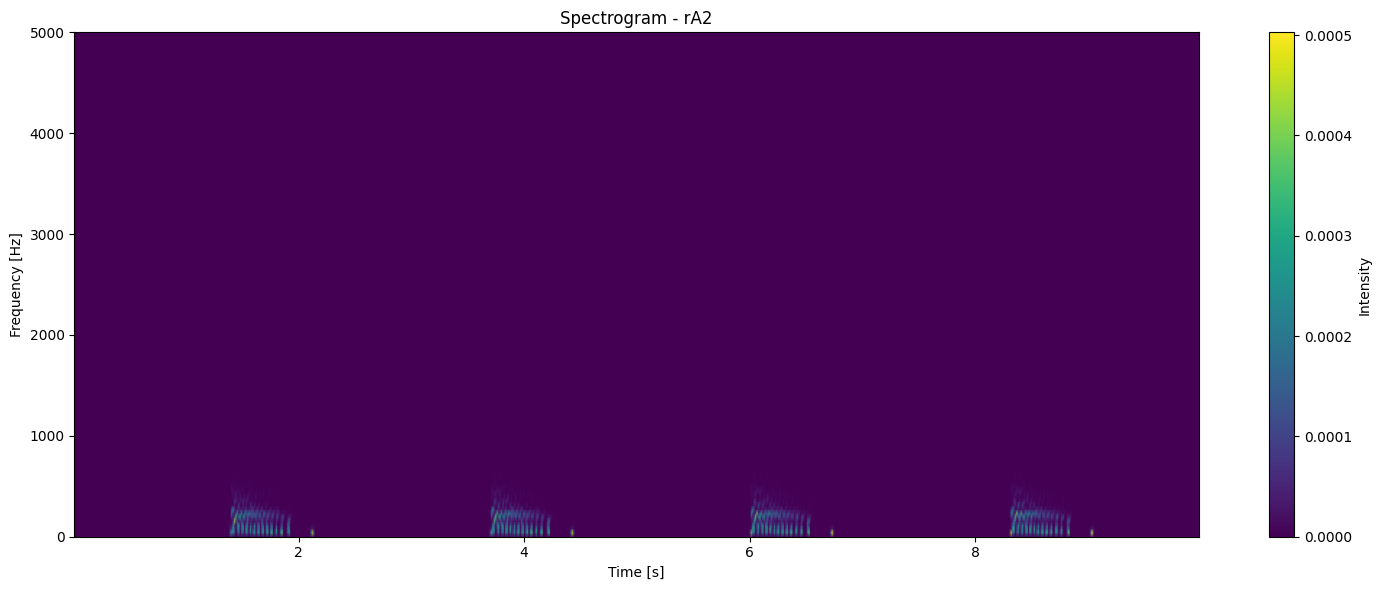

In [1]:
# Import necessary modules
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

# Set a fixed random seed for reproducibility
np.random.seed(42)

# Load Structural Connectivity Matrix
con = connectivity.Connectivity.from_file()
nregions = len(con.region_labels)

# Remove self-connections
con.weights -= con.weights * np.eye(nregions)

# Set conduction speed
con.speed = np.array([3.0])

# Epileptor Model Setup with fixed parameters
mod = models.EpileptorRestingState()
mod.a_rs = np.ones((nregions)) * 1.7402

# Consistent initial conditions for state variables
mod.x0 = np.ones((nregions)) * -2.3  # Non-epileptogenic (NIZ)
mod.x0[[1, 2]] = [-1.9, -1.9]        # EZ: rA1, rA2

# Coupling Setup
coupl = coupling.Difference(a=np.array([0.00015]))

# No noise for clearer results
heunint = integrators.HeunDeterministic(dt=0.1)

# Monitor Setup
mon = monitors.Raw()

# Simulator Configuration without stimulus
sim = simulator.Simulator(
    model=mod,
    connectivity=con,
    coupling=coupl,
    integrator=heunint,
    monitors=[mon]
)
sim.configure()

# Run simulation for 10 seconds (10000 ms)
sim.simulation_length = 10000.0
(time, data), = sim.run()

# Define regions of interest
regions = [1, 2]  # rA1, rA2
labels = ['rA1', 'rA2']

# Extract SEEG-like data for rA1 and rA2
seeg_time = time  # Time vector
seeg_data_rA1 = data[:, 0, regions[0], 0]  # x1 for rA1
seeg_data_rA2 = data[:, 0, regions[1], 0]  # x1 for rA2

# Normalize SEEG data
seeg_data_rA1 = (seeg_data_rA1 - np.min(seeg_data_rA1)) / (np.max(seeg_data_rA1) - np.min(seeg_data_rA1))
seeg_data_rA2 = (seeg_data_rA2 - np.min(seeg_data_rA2)) / (np.max(seeg_data_rA2) - np.min(seeg_data_rA2))

# Plot Time Series for rA1 and rA2
plt.figure(figsize=(15, 6))
plt.plot(seeg_time, seeg_data_rA1, label='rA1', alpha=0.8)
plt.plot(seeg_time, seeg_data_rA2, label='rA2', alpha=0.8)
plt.title('SEEG Time Series - rA1 and rA2')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute FFT for rA1 and rA2
def compute_fft(signal, dt):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, dt)[:N//2]
    amplitude = 2.0/N * np.abs(yf[0:N//2])
    return xf, amplitude

dt = 0.1  # Time step in ms
xf_rA1, yf_rA1 = compute_fft(seeg_data_rA1, dt)
xf_rA2, yf_rA2 = compute_fft(seeg_data_rA2, dt)

# Plot FFT for rA1 and rA2
plt.figure(figsize=(15, 6))
plt.plot(xf_rA1, yf_rA1, label='rA1 FFT', alpha=0.8)
plt.plot(xf_rA2, yf_rA2, label='rA2 FFT', alpha=0.8)
plt.title('FFT of SEEG Signals - rA1 and rA2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute Spectrogram for rA1 and rA2
def plot_spectrogram(signal, dt, label):
    fs = 1000 / dt  # Sampling frequency in Hz
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
    plt.title(f'Spectrogram - {label}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Intensity')
    plt.tight_layout()
    plt.show()

# Plot Spectrogram for rA1 and rA2
plot_spectrogram(seeg_data_rA1, dt, 'rA1')
plot_spectrogram(seeg_data_rA2, dt, 'rA2')